In [20]:
from cdsgd import DSClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score
import wittgenstein as lw
#pca
from sklearn.decomposition import PCA

In [21]:
BreastCancer = pd.read_csv('../data/breast-cancer-wisconsin.csv')
#drop class and id
BreastCancer = BreastCancer.drop(columns=['class', 'id'])
#pasar a numerico la columna bare_nucleoli
BreastCancer['bare_nucleoli'] = pd.to_numeric(BreastCancer['bare_nucleoli'], errors='coerce')
#dropear los nulos
BreastCancer = BreastCancer.dropna()


Shape of BreastCancer data:  (699, 9)
Tipos de las columnas:  clump_thickness       int64
size_uniformity       int64
shape_uniformity      int64
marginal_adhesion     int64
epithelial_size       int64
bare_nucleoli        object
bland_chromatin       int64
normal_nucleoli       int64
mitoses               int64
dtype: object


Kmeans Silhouette Score: 0.5734443556359308 Number of Clusters: 2
Agglomerative Silhouette Score: 0.5687827644847274 Number of Clusters: 2


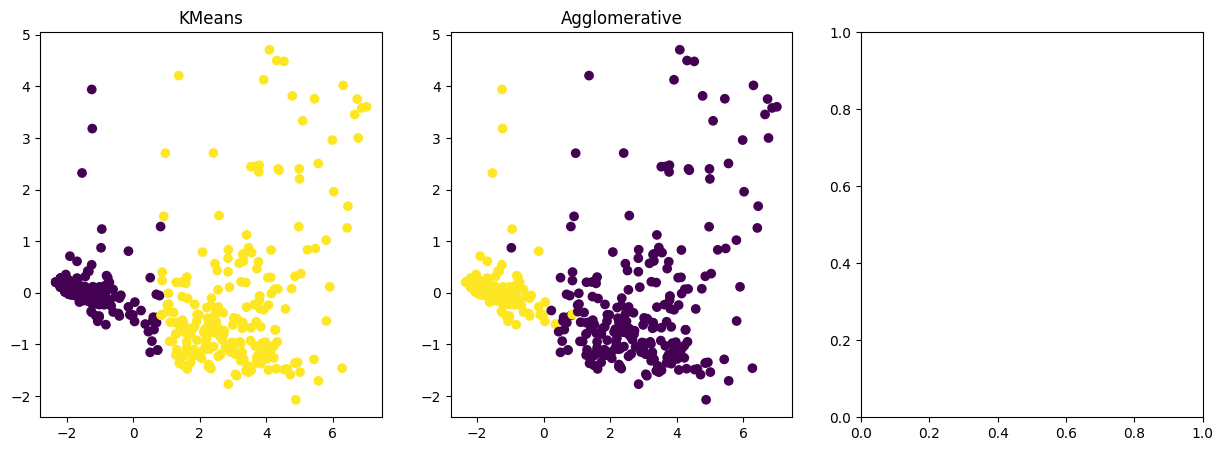

In [22]:
scaler = StandardScaler()
BreastCancer_scaled = scaler.fit_transform(BreastCancer)
BreastCancer = pd.DataFrame(BreastCancer_scaled, columns=BreastCancer.columns)
nClusters = 2
models = []
kmeans = KMeans(n_clusters=nClusters)
kmeans_labels = kmeans.fit_predict(BreastCancer)
models.append({'model': kmeans, 'name': 'KMeans', 'labels': kmeans_labels})
print('Kmeans Silhouette Score:', silhouette_score(BreastCancer, kmeans_labels), "Number of Clusters:", len(np.unique(kmeans_labels)))

agg = AgglomerativeClustering(n_clusters=nClusters)
agg_labels = agg.fit_predict(BreastCancer)
models.append({'model': agg, 'name': 'Agglomerative', 'labels': agg_labels})
print('Agglomerative Silhouette Score:', silhouette_score(BreastCancer, agg_labels), "Number of Clusters:", len(np.unique(agg_labels)))

# visualize the clusters
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(BreastCancer)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()

## Lime

In [23]:
clustterToExplain = 1
i = 100 # instance to explain

#KMeans
y = (kmeans_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(BreastCancer, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(BreastCancer, y)
print('KMeans Accuracy:', accuracy_score(y, clf.predict(BreastCancer)))
explainer = LimeTabularExplainer(BreastCancer.values, mode='classification', feature_names=BreastCancer.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(BreastCancer.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

#Agglomerative
y = (agg_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(BreastCancer, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(BreastCancer, y)
print('Agglomerative Accuracy:', accuracy_score(y, clf.predict(BreastCancer)))
explainer = LimeTabularExplainer(BreastCancer.values, mode='classification', feature_names=BreastCancer.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(BreastCancer.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

KMeans Accuracy: 0.9956076134699854


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Agglomerative Accuracy: 0.9970717423133236


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Decision tree

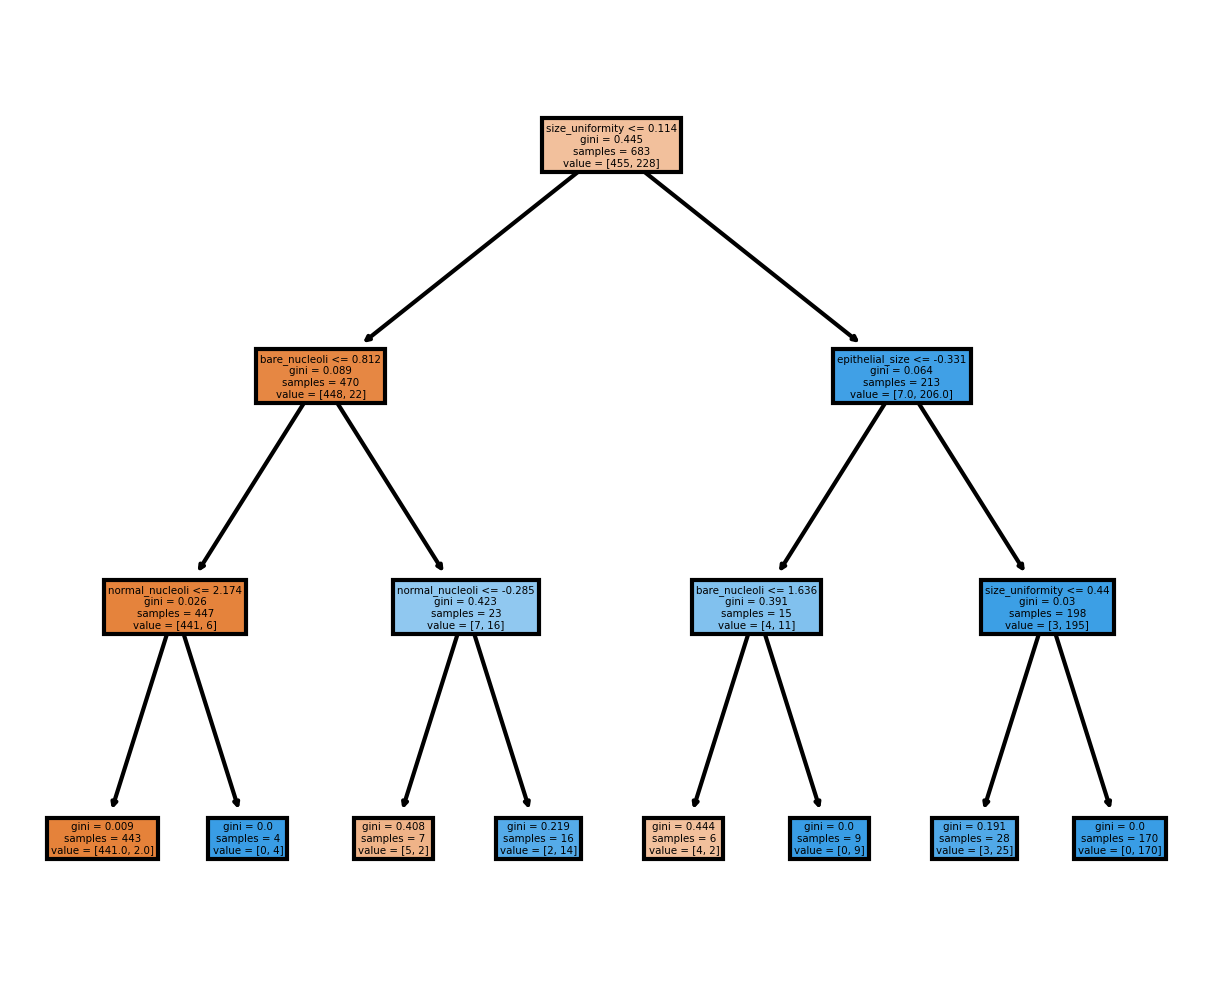

Decision Tree Accuracy: 0.9838945827232797


In [33]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(BreastCancer, kmeans_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=BreastCancer.columns)
plt.show()
y_pred = dt.predict(BreastCancer)
print('Decision Tree Accuracy:', accuracy_score(kmeans_labels, y_pred))


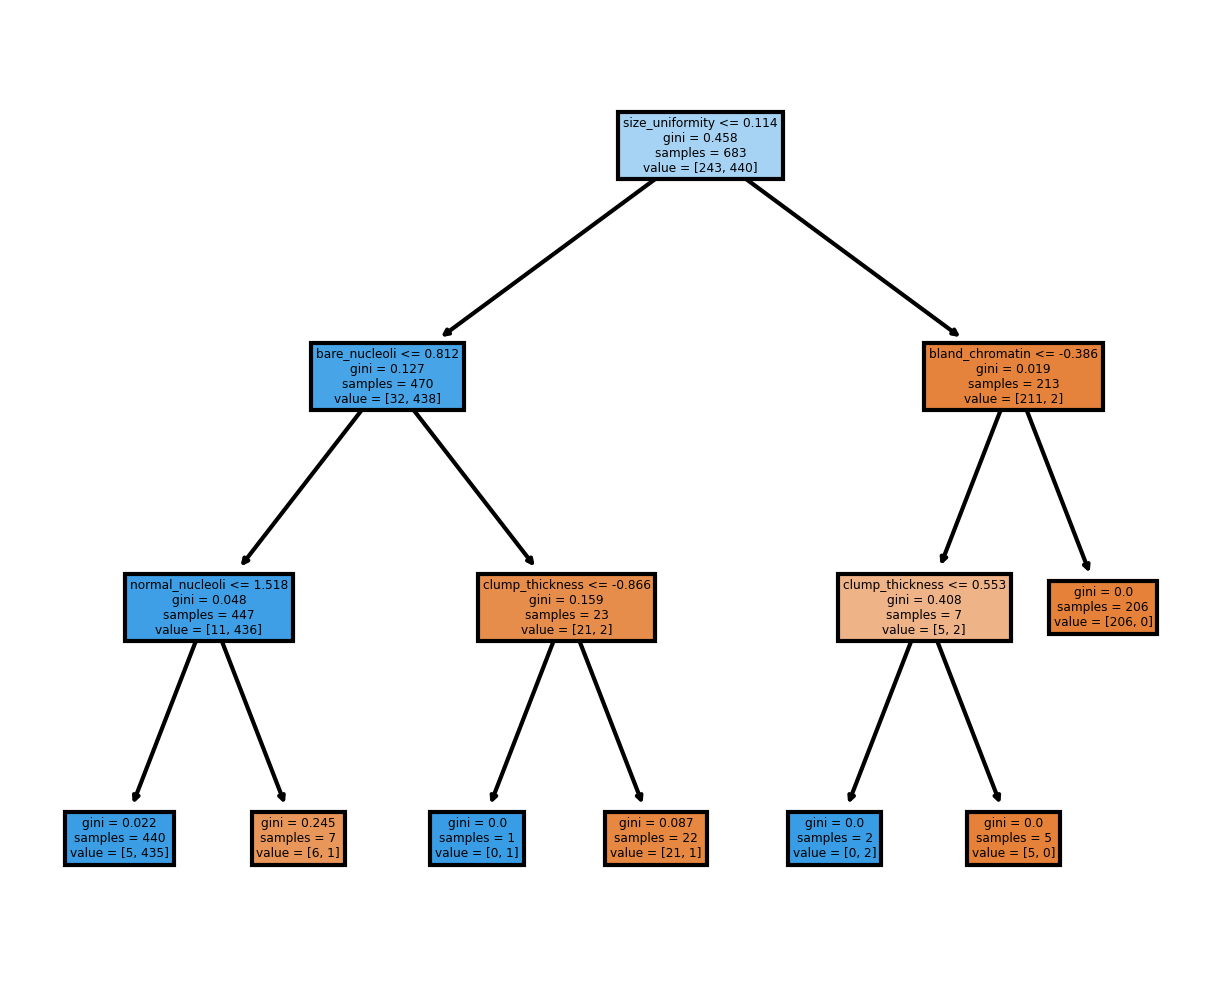

Decision Tree Accuracy: 0.9897510980966325


In [32]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(BreastCancer, agg_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=BreastCancer.columns)
plt.show()
y_pred = dt.predict(BreastCancer)
print('Decision Tree Accuracy:', accuracy_score(agg_labels, y_pred))

# RIPPER

In [31]:
pos = 0
# cambiamos las etiquetas para que el positivo sea el cluster 0
kmeans_labels_pos = (kmeans_labels == pos).astype(int)
agg_labels_pos = (agg_labels == pos).astype(int)
# KMeans
ripper = lw.RIPPER()
df = pd.concat([BreastCancer, pd.DataFrame(kmeans_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(BreastCancer)
print('RIPPER Accuracy KMeans:', accuracy_score(kmeans_labels_pos, y_pred))
# Agglomerative
ripper = lw.RIPPER()
df = pd.concat([BreastCancer, pd.DataFrame(agg_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(BreastCancer)
print('RIPPER Accuracy Agglomerative:', accuracy_score(agg_labels_pos, y_pred))

[[size_uniformity=-0.7022120099523874] V [epithelial_size=-0.5556084958608782^size_uniformity=-0.37572405706097783] V [size_uniformity=-0.04923610416956831^normal_nucleoli=-0.6129273637126224] V [size_uniformity=-0.04923610416956831^epithelial_size=-0.5556084958608782] V [size_uniformity=-0.37572405706097783^normal_nucleoli=-0.6129273637126224] V [clump_thickness=-0.5116433711982238^shape_uniformity=-0.406921417352306]]
RIPPER Accuracy KMeans: 0.9736456808199122
[[bare_nucleoli=1.7728672418029487] V [size_uniformity=2.2361795660702986] V [normal_nucleoli=2.337475537416187] V [size_uniformity=0.2772518487218412^normal_nucleoli=0.04271772542711312] V [bare_nucleoli=1.2235960573387101] V [shape_uniformity=0.2627829875913686^bland_chromatin=-0.18182715767693225^size_uniformity=0.9302277545046603] V [epithelial_size=0.3447013562695602^shape_uniformity=1.2673395950068806] V [shape_uniformity=1.6021917974787179] V [bland_chromatin=1.4522247988144457] V [shape_uniformity=0.597635190063206] V [

## DSClustering

Optimization started
Processing epoch	373	0.0004	

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Training time: 47.63s, epochs: 400

Least training loss reached: 0.000
CD-SGD Silhouette Score: 0.5723245446077304 Number of Clusters: 2


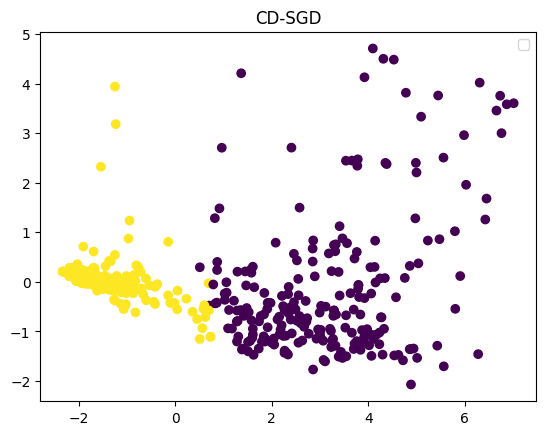

In [27]:
cdsgd = DSClustering(data=BreastCancer,cluster=2)
cdsgd.generate_categorical_rules()
cdsgd_labels = cdsgd.predict()
models.append({'model': cdsgd, 'name': 'CD-SGD con 2 clusters', 'labels': cdsgd_labels})
print('CD-SGD Silhouette Score:', silhouette_score(BreastCancer, cdsgd_labels), "Number of Clusters:", len(np.unique(cdsgd_labels)))
#vvisualize the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(BreastCancer)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cdsgd_labels, cmap='viridis')
plt.title('CD-SGD')
plt.legend()
plt.show()

In [28]:
cdsgd.print_most_important_rules()



Most important rules for Cluster 0

	[0.492] R44: mitoses > 0.604
			0: 0.492	1: 0.000	Unc: 0.508

	[0.398] R75: Negative size_uniformity - 0.012, shape_uniformity - 0.029
			0: 0.398	1: 0.000	Unc: 0.602

	[0.362] R36: bland_chromatin > 0.647
			0: 0.362	1: 0.000	Unc: 0.638

	[0.360] R119: Negative marginal_adhesion - 0.011, normal_nucleoli - -0.071
			0: 0.360	1: 0.000	Unc: 0.640

	[0.354] R39: -0.071 < normal_nucleoli < 0.549
			0: 0.354	1: 0.000	Unc: 0.646

	[0.348] R16: size_uniformity > 0.692
			0: 0.348	1: 0.000	Unc: 0.652

	[0.329] R101: Negative shape_uniformity - 0.029, bland_chromatin - -0.014
			0: 0.329	1: 0.000	Unc: 0.671

	[0.323] R28: epithelial_size > 0.740
			0: 0.323	1: 0.000	Unc: 0.677

	[0.317] R24: marginal_adhesion > 0.695
			0: 0.317	1: 0.000	Unc: 0.683

	[0.317] R35: -0.014 < bland_chromatin < 0.647
			0: 0.317	1: 0.000	Unc: 0.683

	[0.299] R32: bare_nucleoli > 0.646
			0: 0.299	1: 0.000	Unc: 0.701

	[0.289] R12: clump_thickness > 0.666
			0: 0.289	1: 0.000	Un

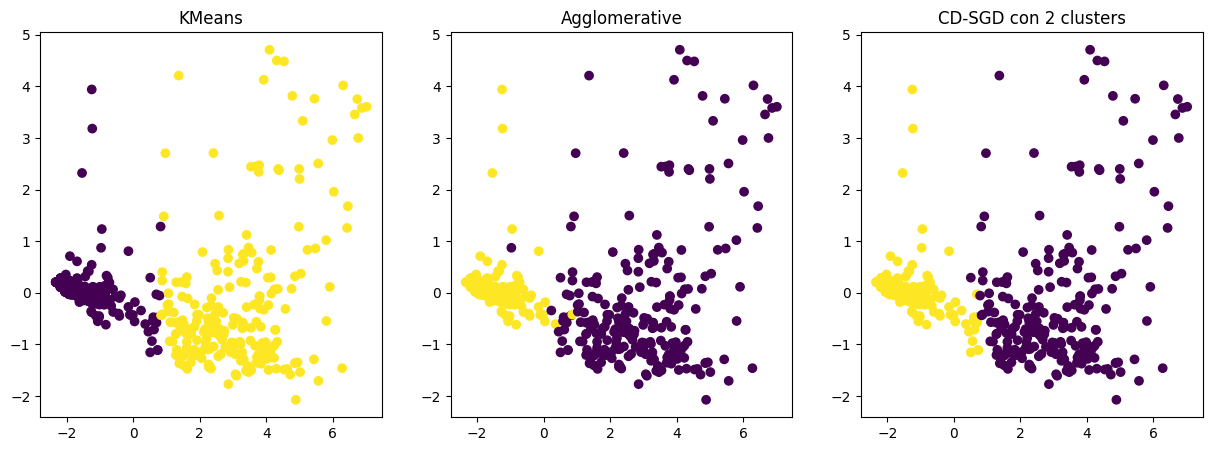

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(BreastCancer)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()